In [1]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
%matplotlib inline

from spacy.vectors import Vectors
from spacy.strings import StringStore
from scipy.cluster.hierarchy import dendrogram, linkage
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('../ProteomeXchange/scraped_pubmed_latest.csv')
df = df[df.Abstract.notnull()]
df.reset_index(inplace=True)
df.head(2)

,index,Dataset ID,PMID,Title,Authors,Journal,PubDate,Abstract,Keywords
0,0,PXD000001,23692960,Using R and Bioconductor for proteomics data a...,"Laurent Gatto, Andy Christoforou",Biochimica et biophysica acta,Jan-2014,"This review presents how R, the popular statis...","Data analysis statistics, Mass spectrometry, Q..."
1,2,PXD000003,22786679,Reproducible quantification of cancer-associat...,"Ruth Hüttenhain, Martin Soste, Nathalie Selevs...",Science translational medicine,Jul-2012,The rigorous testing of hypotheses on suitable...,NaN


In [3]:
len(df)

4326

In [4]:
bio_vector = Vectors()
bio_vector.from_disk('/home/ryohayama/nlp_vectors/biomedicalWordVectors/vectors.txt')
bio_nlp = spacy.load('en',vector=bio_vector)

In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
%%time
# Calculate pairwise distance using pdist. Use cosine distance here
# Collect vector from each doc, create a vector of coordinates (m x n matrix)
m = len(df)
labels = list(df['Dataset ID'].iloc[:m])
docs = [bio_nlp(df.Abstract.iloc[i]) for i in range(m)]
docs_cleaned  = []
for doc in docs:
    doc_cln = [token.text for token in doc if token not in stop_words]
    doc_cln = ' '.join(doc_cln)
    docs_cleaned.append(bio_nlp(doc_cln))
    
vecs = np.array([doc.vector for doc in docs_cleaned])
print(vecs.shape)

# Calculate pairwise cosine distance
Xcos_dist = scipy.spatial.distance.pdist(vecs, metric='cosine')
print(Xcos_dist.shape)

(4326, 384)
(9354975,)
CPU times: user 29min 58s, sys: 29min 29s, total: 59min 27s
Wall time: 7min 39s


##### Clustering ('ward' linkage)

In [7]:
Z = linkage(Xcos_dist, 'ward')

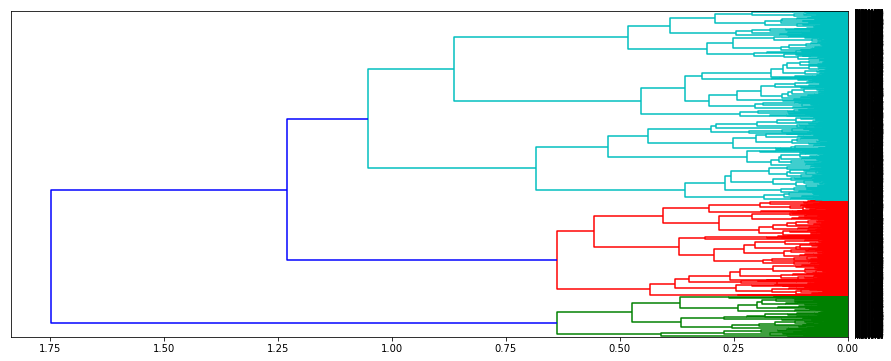

In [8]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
dn = dendrogram(Z, ax=ax, orientation='left', labels=labels)

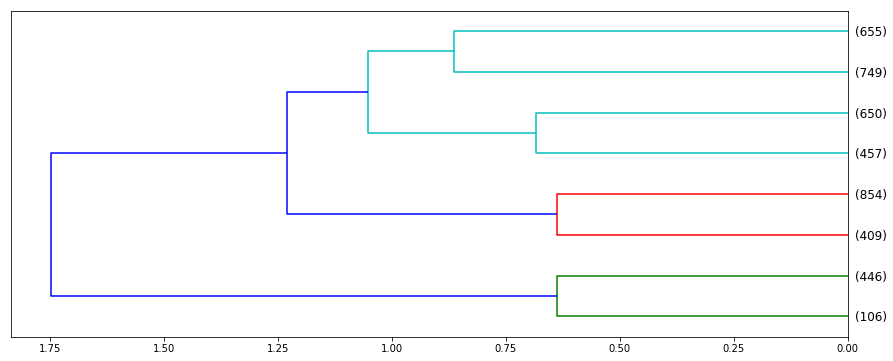

In [9]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
dn = dendrogram(Z, truncate_mode='lastp', p =8, ax=ax, orientation='left')

In [10]:
fcluster = scipy.cluster.hierarchy.fcluster(
    Z, 0.5, criterion='distance', depth=2, R=None, monocrit=None)

In [11]:
cluster_counts = pd.Series(fcluster).value_counts()
cluster_counts.sort_index()#.sort_values(ascending=True)

1     106
2     446
3     409
4     387
5     467
6     457
7     222
8     428
9     749
10    655
dtype: int64

In [12]:
len(cluster_counts)

10

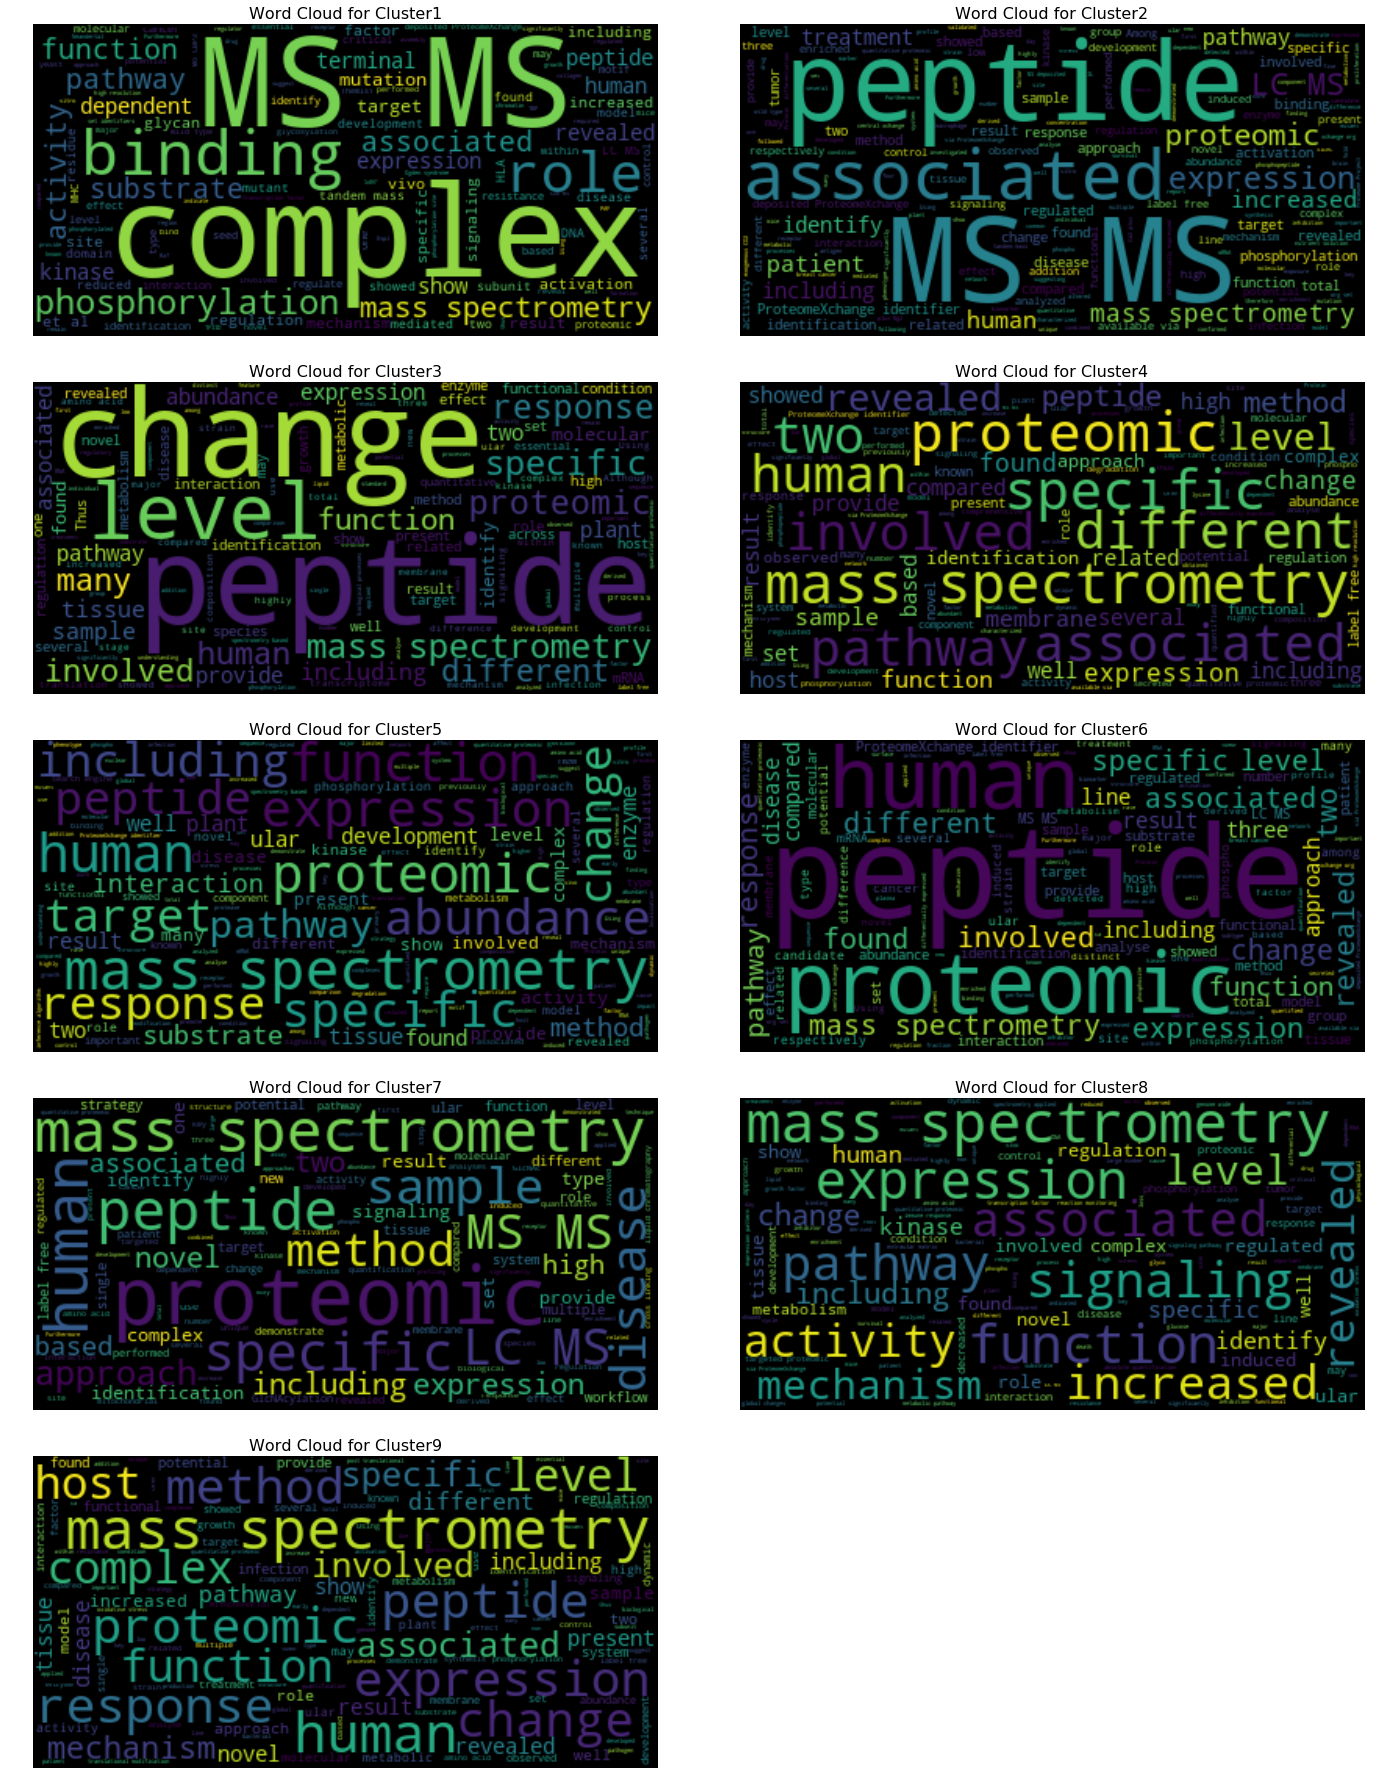

In [13]:
fig = plt.figure(figsize=(20, 25))
for i in range(1, len(cluster_counts)):
    clstr = (np.argwhere(fcluster == i).flatten())
    clstr_text = ' '.join([docs_cleaned[j].text for j in clstr])
    clstr_text = clstr_text.replace('protein', '')
    clstr_text = clstr_text.replace('analysis', '')
    clstr_text = clstr_text.replace('identified', '')
    clstr_text = clstr_text.replace('proteome', '')
    clstr_text = clstr_text.replace('data', '')
    clstr_text = clstr_text.replace('studies', '')
    clstr_text = clstr_text.replace('study', '')
    clstr_text = clstr_text.replace('cell', '')
    clstr_text = clstr_text.replace('using', '')
    clstr_text = clstr_text.replace('gene', '')
    clstr_text = clstr_text.replace('used', '')
    wc = WordCloud().generate(clstr_text)
    
    ax = fig.add_subplot(5, 2, i)
    ax.set_title('Word Cloud for Cluster%d' % i, fontsize=16)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')

fig.tight_layout()

In [14]:
fcluster2 = scipy.cluster.hierarchy.fcluster(
    Z, 1, criterion='distance', depth=2, R=None, monocrit=None)

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(n_components=4)
vecs_pca = pca.fit_transform(vecs)

In [17]:
vecs_pca.shape

(4326, 4)

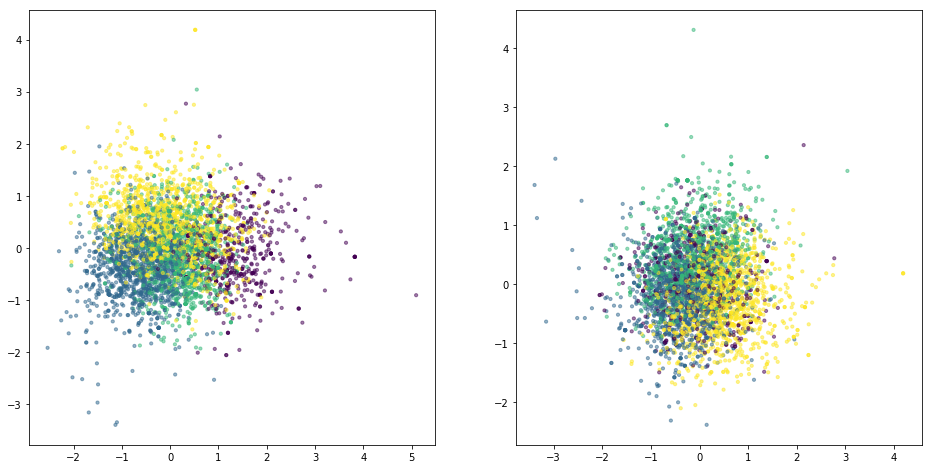

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].scatter(vecs_pca[:, 0], vecs_pca[:, 1], c= fcluster2, s=10, alpha=0.5)
axes[1].scatter(vecs_pca[:, 1], vecs_pca[:, 2], c= fcluster2, s=10, alpha=0.5)

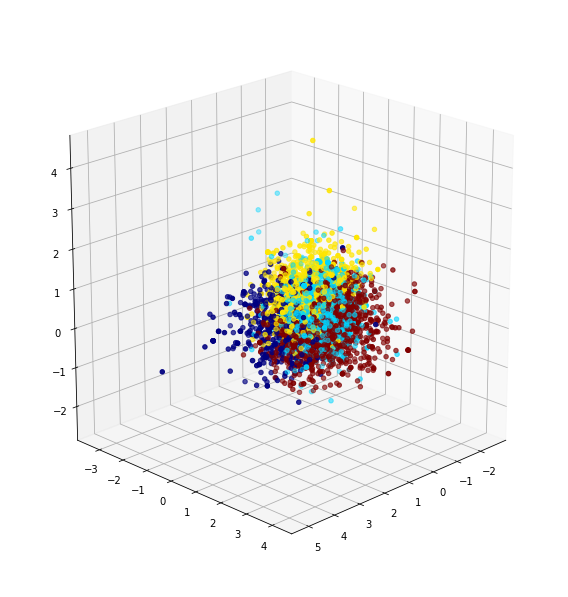

In [32]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=20, azim=45, rect=[0, 0, .95, 1])

ax.scatter(vecs_pca[:, 0], vecs_pca[:, 1], vecs_pca[:, 2], c=fcluster2, marker = 'o', s=20, cmap = cm.jet)